<a href="https://colab.research.google.com/github/GVSU-CIS635/projects-outliers/blob/ML_Models/NBeatsNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##importing libraries

In [ ]:
import math
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error


##loading dataset

In [ ]:
df = pd.read_csv('streamflow_filled.csv')
df.head()

,Date,Unnamed: 0,Year,Month,Day,Q (m3/s)
0,1967-01-01,11963,1967,1,1,2690.0
1,1967-01-02,11964,1967,1,2,2650.0
2,1967-01-03,11965,1967,1,3,2650.0
3,1967-01-04,11966,1967,1,4,2610.0
4,1967-01-05,11967,1967,1,5,2570.0


##exploring data

In [ ]:
df.isnull().sum()

,0
Date,0
Unnamed: 0,0
Year,0
Month,0
Day,0
Q (m3/s),0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18628 entries, 0 to 18627
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        18628 non-null  object 
 1   Unnamed: 0  18628 non-null  int64  
 2   Year        18628 non-null  int64  
 3   Month       18628 non-null  int64  
 4   Day         18628 non-null  int64  
 5   Q (m3/s)    18628 non-null  float64
dtypes: float64(1), int64(4), object(1)
memory usage: 873.3+ KB


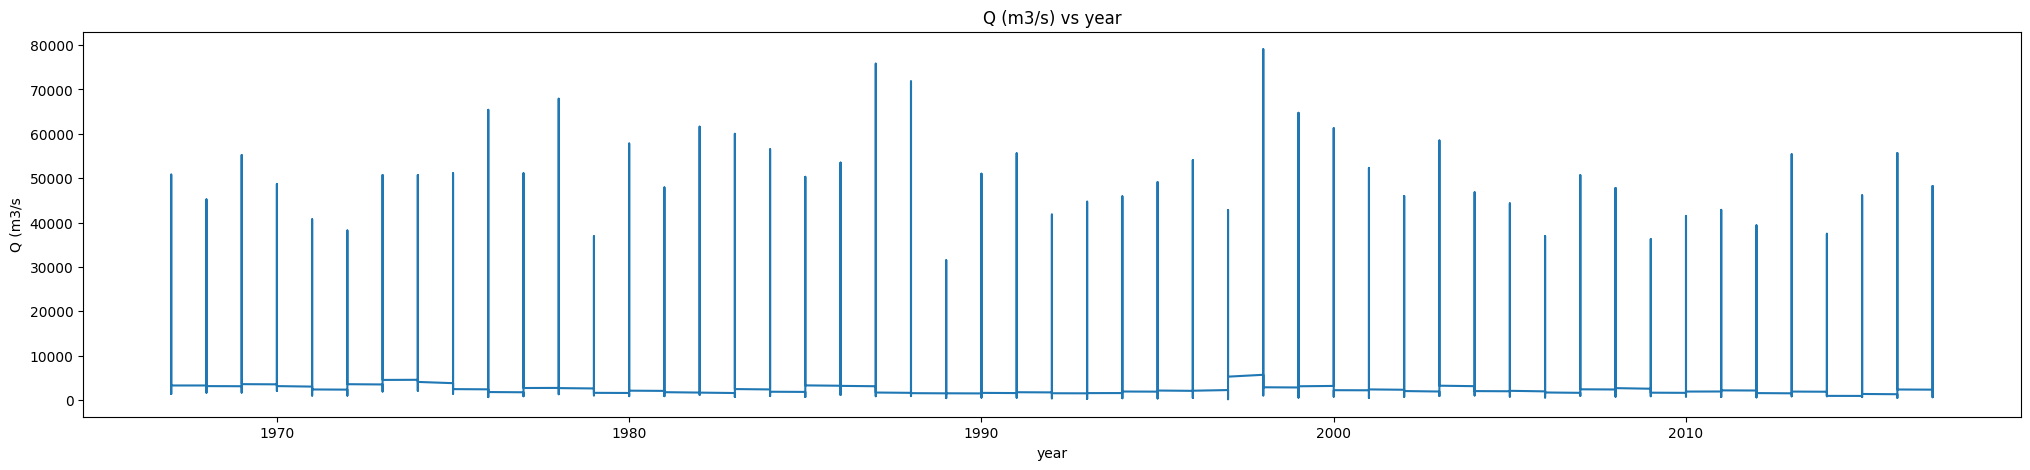

In [ ]:
df.info()
plt.figure(figsize=(25,5))
plt.plot(df['Year'] , df['Q (m3/s)'] )
plt.title('Q (m3/s) vs year')
plt.xlabel('year')
plt.ylabel('Q (m3/s')

plt.show()

Monthly dataset

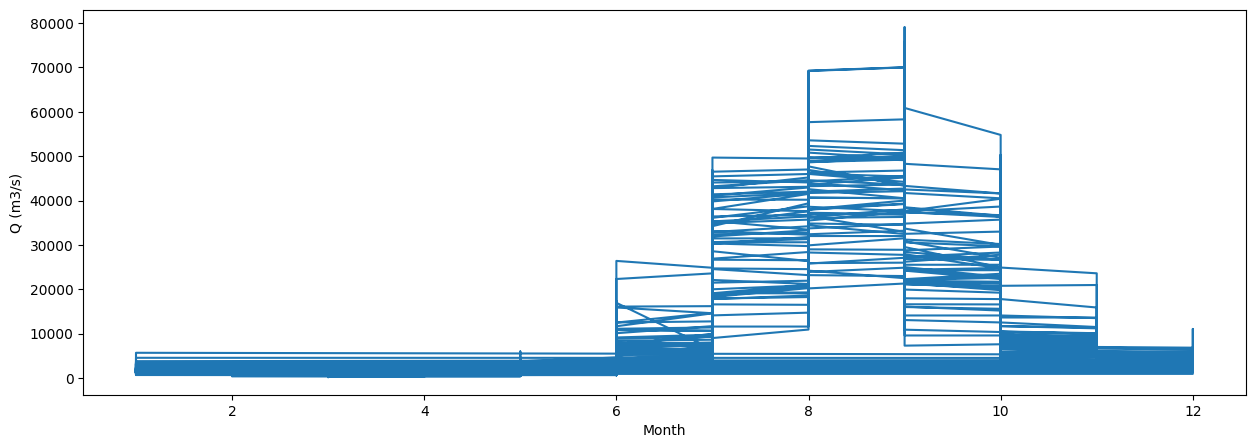

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(df.Month , df['Q (m3/s)'] )
plt.xlabel('Month')
plt.ylabel('Q (m3/s)')
plt.show()

Select target variable (Q m³/s)

In [ ]:
target_col = 'Q (m3/s)'
series = df[target_col].astype(float)

Plot the time series

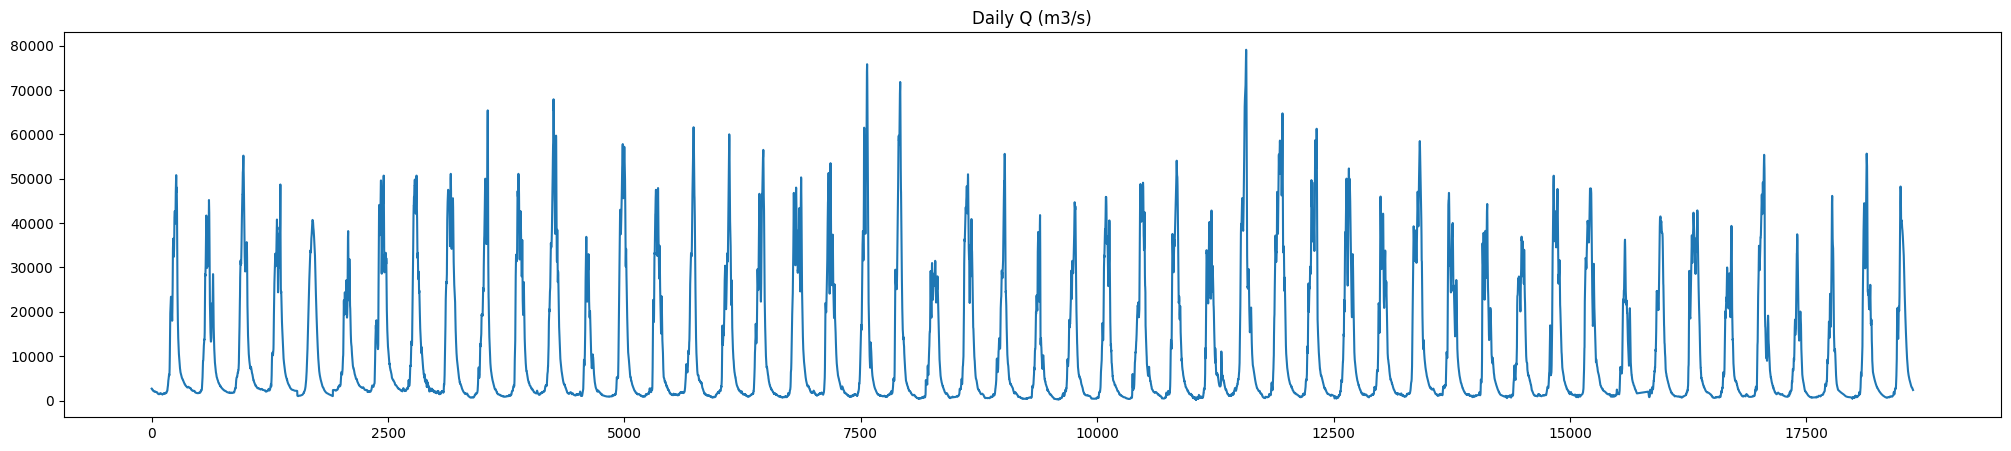

In [ ]:
series.plot(figsize=(25,5), title = 'Daily Q (m3/s)')
plt.show()

In [ ]:
TARGET_COLUMN = 'Q (m3/s)'
y = df[TARGET_COLUMN].values.reshape(-1, 1)
scaler = MinMaxScaler()
y_scaled = scaler.fit_transform(y)
series = torch.tensor(y_scaled , dtype = torch.float32).squeeze()
print('series length :' , len(series))
print('series shape :' , series.shape[:10])

series length : 18628
series shape : torch.Size([18628])


In [ ]:
from torch.utils.data import Dataset, DataLoader
INPUT_WINDOW = 365*3
OUTPUT_WINDOW = 365*5
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, series, input_window, output_window):
        # Ensure series is a 1D torch tensor
        if not isinstance(series, torch.Tensor):
            series = torch.tensor(series, dtype=torch.float32)
        if series.ndim != 1:
            series = series.squeeze()
        self.series = series.float()
        self.input_window = input_window
        self.output_window = output_window
        self.length = len(series) - input_window - output_window + 1
        if self.length <= 0:
            raise ValueError("Series too short for given input/output window")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx < 0 or idx >= self.length:
            raise IndexError(f"Index {idx} out of range")
        x = self.series[idx : idx + self.input_window].clone().unsqueeze(1)
        y = self.series[idx + self.input_window : idx + self.input_window + self.output_window].clone()
        return x, y


dataset = TimeSeriesDataset(series, INPUT_WINDOW, OUTPUT_WINDOW)


print("Total sequences available:", len(dataset))

train_size = int(len(dataset) * 0.7)
val_size = int(len(dataset) * 0.15)
test_size = len(dataset) - train_size - val_size

train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, val_size, test_size],
                                                         generator=torch.Generator().manual_seed(42))

print("Train sequences:", len(train_ds))
print("Validation sequences:", len(val_ds))
print("Test sequences:", len(test_ds))

Total sequences available: 15709
Train sequences: 10996
Validation sequences: 2356
Test sequences: 2357


In [ ]:
import torch.nn as nn

class NBeatsBlock(nn.Module):
    def __init__(self, input_size, output_size, hidden_units=128, fc_layers=4, dropout=0.0):
        super().__init__()
        layers = [nn.Linear(input_size, hidden_units), nn.ReLU()]
        for _ in range(fc_layers - 1):
            layers.append(nn.Linear(hidden_units, hidden_units))
            layers.append(nn.ReLU())
            if dropout > 0:
                layers.append(nn.Dropout(dropout))
        self.fc = nn.Sequential(*layers)
        # Output head: predicts backcast+forecast
        self.theta = nn.Linear(hidden_units, input_size + output_size)
        self.input_size = input_size
        self.output_size = output_size

    def forward(self, x):
        # x: (batch, input_size)
        x = self.fc(x)
        theta = self.theta(x)
        backcast = theta[:, :self.input_size]
        forecast = theta[:, self.input_size:]
        return backcast, forecast

class NBeatsNet(nn.Module):
    def __init__(self, input_size, output_size, stacks=3, blocks_per_stack=3, hidden_units=128, fc_layers=4, dropout=0.0):
        super().__init__()
        self.blocks = nn.ModuleList()
        for _ in range(stacks * blocks_per_stack):
            self.blocks.append(NBeatsBlock(input_size, output_size, hidden_units, fc_layers, dropout))

    def forward(self, x):

        batch = x.shape[0]
        x = x.view(batch, -1)
        residual = x.clone()
        forecast = x.new_zeros(batch, self.blocks[0].output_size)
        for block in self.blocks:
            backcast, block_forecast = block(residual)
            residual = residual - backcast
            forecast = forecast + block_forecast
        return forecast


model = NBeatsNet(INPUT_WINDOW, OUTPUT_WINDOW,
                  stacks=3,
                  blocks_per_stack=3,
                  hidden_units=128,
                  fc_layers=4,
                  dropout=0.0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

print(model)


NBeatsNet(
  (blocks): ModuleList(
    (0-8): 9 x NBeatsBlock(
      (fc): Sequential(
        (0): Linear(in_features=1095, out_features=128, bias=True)
        (1): ReLU()
        (2): Linear(in_features=128, out_features=128, bias=True)
        (3): ReLU()
        (4): Linear(in_features=128, out_features=128, bias=True)
        (5): ReLU()
        (6): Linear(in_features=128, out_features=128, bias=True)
        (7): ReLU()
      )
      (theta): Linear(in_features=128, out_features=2920, bias=True)
    )
  )
)


In [ ]:
# Test first 3 items
for i in range(3):
    x, y = dataset[i]
    print(f"Sample {i} shapes: x={x.shape}, y={y.shape}, type x={type(x)}, type y={type(y)}")


Sample 0 shapes: x=torch.Size([1095, 1]), y=torch.Size([1825]), type x=<class 'torch.Tensor'>, type y=<class 'torch.Tensor'>
Sample 1 shapes: x=torch.Size([1095, 1]), y=torch.Size([1825]), type x=<class 'torch.Tensor'>, type y=<class 'torch.Tensor'>
Sample 2 shapes: x=torch.Size([1095, 1]), y=torch.Size([1825]), type x=<class 'torch.Tensor'>, type y=<class 'torch.Tensor'>


In [ ]:
import torch.optim as optim
import time


BATCH_SIZE = 8
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

best_val = float('inf')
patience = 8
no_improve = 0
EPOCHS = 60

train_losses = []
val_losses = []

for epoch in range(1, EPOCHS + 1):
    t0 = time.time()

    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        xb = xb.to(device).float()
        yb = yb.to(device).float()
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)


    model.eval()
    running_val = 0.0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb = xb.to(device).float()
            yb = yb.to(device).float()
            pred = model(xb)
            loss = criterion(pred, yb)
            running_val += loss.item()
    val_loss = running_val / len(val_loader)
    val_losses.append(val_loss)

    # Early stopping check
    if val_loss < best_val:
        best_val = val_loss
        best_state = {k:v.cpu() for k,v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1

    print(f"Epoch {epoch} | Train Loss: {train_loss:.6f} | Val Loss: {val_loss:.6f} | Time: {time.time()-t0:.1f}s")

    if no_improve >= patience:
        print("Early stopping triggered!")
        break

# Load best model
model.load_state_dict(best_state)
print("Best validation loss:", best_val)


Epoch 1 | Train Loss: 0.006838 | Val Loss: 0.005868 | Time: 18.6s
Epoch 2 | Train Loss: 0.005502 | Val Loss: 0.004995 | Time: 19.5s
Epoch 3 | Train Loss: 0.004630 | Val Loss: 0.004145 | Time: 18.9s
Epoch 4 | Train Loss: 0.003582 | Val Loss: 0.003195 | Time: 18.8s
Epoch 5 | Train Loss: 0.002813 | Val Loss: 0.002673 | Time: 18.3s
Epoch 6 | Train Loss: 0.002330 | Val Loss: 0.002394 | Time: 20.3s
Epoch 7 | Train Loss: 0.002225 | Val Loss: 0.001958 | Time: 18.8s
Epoch 8 | Train Loss: 0.001954 | Val Loss: 0.002295 | Time: 18.0s
Epoch 9 | Train Loss: 0.002062 | Val Loss: 0.001703 | Time: 18.7s
Epoch 10 | Train Loss: 0.001649 | Val Loss: 0.001752 | Time: 17.8s
Epoch 11 | Train Loss: 0.001822 | Val Loss: 0.001611 | Time: 18.6s
Epoch 12 | Train Loss: 0.001504 | Val Loss: 0.001614 | Time: 17.8s
Epoch 13 | Train Loss: 0.001553 | Val Loss: 0.001632 | Time: 18.2s
Epoch 14 | Train Loss: 0.001469 | Val Loss: 0.001628 | Time: 17.8s
Epoch 15 | Train Loss: 0.001460 | Val Loss: 0.001547 | Time: 19.3s
Epoc

In [ ]:
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error


model.eval()
y_trues = []
y_preds = []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device).float()
        pred = model(xb).cpu().numpy()
        true = yb.cpu().numpy()
        y_preds.append(pred)
        y_trues.append(true)

y_preds = np.vstack(y_preds)
y_trues = np.vstack(y_trues)

print("Shapes -> y_trues:", y_trues.shape, "y_preds:", y_preds.shape)

pred_flat = y_preds.flatten().reshape(-1, 1)
true_flat = y_trues.flatten().reshape(-1, 1)

pred_inv = scaler.inverse_transform(y_preds.reshape(-1, 1)).reshape(y_preds.shape)
true_inv = scaler.inverse_transform(y_trues.reshape(-1, 1)).reshape(y_trues.shape)


true_t = torch.from_numpy(true_inv).float()
pred_t = torch.from_numpy(pred_inv).float()

min_true = float(true_t.min().item())
near_zero_count = int((true_t.abs() < 1e-6).sum().item())
total_values = true_t.numel()

print(f"Min true value: {min_true:.6f}")
print(f"Values near zero (<1e-6): {near_zero_count} / {total_values}")


mse = mean_squared_error(true_t.flatten().numpy(), pred_t.flatten().numpy())
rmse = math.sqrt(mse)
mae = mean_absolute_error(true_t.flatten().numpy(), pred_t.flatten().numpy())


eps = 1e-8
ape = torch.abs((pred_t - true_t) / (true_t + eps)) * 100.0

mape = float(torch.mean(ape).item())
max_ape = float(torch.max(ape).item())
mean_ape = float(torch.mean(ape).item())

print("\n=== Test metrics (original units) ===")
print(f"MSE   : {mse:.6f}")
print(f"RMSE  : {rmse:.6f}")
print(f"MAE   : {mae:.6f}")
print(f"MAPE  : {mape:.3f}%")




Shapes -> y_trues: (2357, 1825) y_preds: (2357, 1825)
Min true value: 182.840012
Values near zero (<1e-6): 0 / 4301525

=== Test metrics (original units) ===
MSE   : 7171543.500000
RMSE  : 2677.973768
MAE   : 1694.524658
MAPE  : 42.135%


In [ ]:
print(y_trues[0][:10])
print(y_preds[0][:10])


[0.7051403  0.7139947  0.71190536 0.6999423  0.6845409  0.64801025
 0.6203745  0.6000642  0.5838692  0.5866229 ]
[0.5894355  0.5968674  0.60626656 0.6142507  0.62296045 0.62732005
 0.6335092  0.6372439  0.6389799  0.6389369 ]


In [ ]:
OUTPUT_WINDOW = y_preds.shape[1]
days_per_year = 365
if OUTPUT_WINDOW >= days_per_year:
    num_years = OUTPUT_WINDOW // days_per_year
    print("\nPer-year MAPE (averaged across all test samples):")
    for y in range(num_years):
        s = y * days_per_year
        e = s + days_per_year
        ape_year = torch.abs((pred_t[:, s:e] - true_t[:, s:e]) / (true_t[:, s:e] + eps)) * 100.0
        print(f" Year {y+1}: MAPE = {float(torch.mean(ape_year).item()):.3f}%")


Per-year MAPE (averaged across all test samples):
 Year 1: MAPE = 41.911%
 Year 2: MAPE = 40.673%
 Year 3: MAPE = 42.348%
 Year 4: MAPE = 41.791%
 Year 5: MAPE = 43.951%


###checking the minimun absolute value in the test

In [ ]:
sample_idx = 0
plot_days = min(365, OUTPUT_WINDOW)

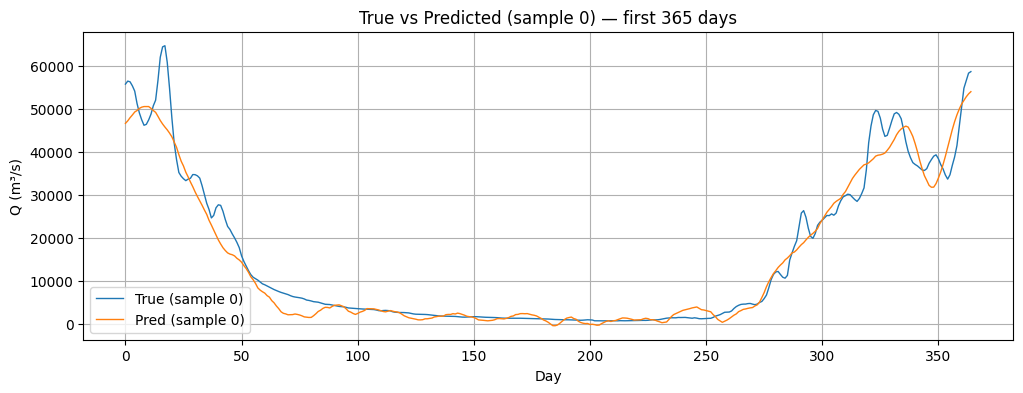

In [ ]:
plt.figure(figsize=(12,4))
plt.plot(true_inv[sample_idx, :plot_days], label='True (sample 0)', linewidth=1)
plt.plot(pred_inv[sample_idx, :plot_days], label='Pred (sample 0)', linewidth=1)
plt.title("True vs Predicted (sample 0) — first {} days".format(plot_days))
plt.xlabel("Day")
plt.ylabel("Q (m³/s)")
plt.legend()
plt.grid(True)
plt.show()

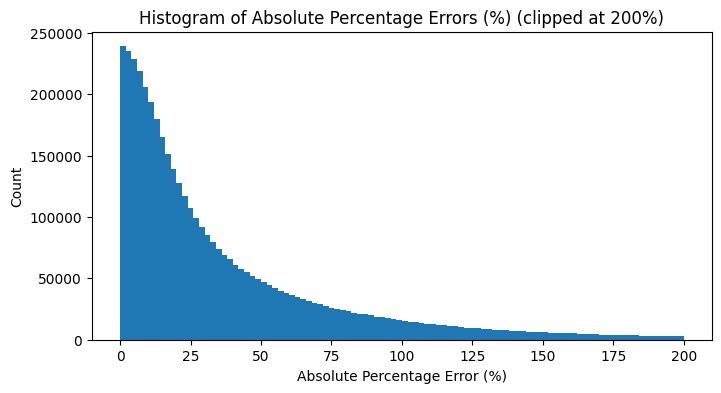

In [ ]:
plt.figure(figsize=(8,4))
plt.hist(ape.flatten().numpy(), bins=100, range=(0, 200))
plt.title("Histogram of Absolute Percentage Errors (%) (clipped at 200%)")
plt.xlabel("Absolute Percentage Error (%)")
plt.ylabel("Count")
plt.show()